# Learning with springs and sticks

Author: [Luis Mantilla Calderón](https://lui.so), 2024

In [21]:
import sys
sys.path.append('./src')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchsde

from springs_sdes import S3DE, GS3DE, GGS3DE
# from springs_sdes_torch import S3DE, GS3DE, GGS3DE
from springs_plot import animate_springs, generalized_animation, generalized_animation_3d
from viz import evolution_plot, plot_evolution_ud_vs_od

In [22]:
np.random.seed(100)
u_i = torch.tensor([1,2,3,4,5,6])
u_max = max(u_i)
u_min = min(u_i)
y_i = torch.tensor(np.random.rand(6))

batch_size, state_size, t_size = 100, 4, 200

In [23]:
sde_ud = S3DE(u_i, y_i, friction=1, temp=1, k=1e-9, M=1e-9)
sde_od = S3DE(u_i, y_i, friction=10, temp=1, k=1e-9, M=1e-9)

ts = torch.linspace(0, 20, t_size)
y0 = torch.rand(size=(batch_size, state_size))

In [6]:
sde_ud = S3DE(u_i, y_i, friction=1, temp=1, k=1e-9, M=1e-9)
sde_od = S3DE(u_i, y_i, friction=10, temp=1, k=1e-9, M=1e-9)

ts = torch.linspace(0, 20, t_size)
y0 = torch.rand(size=(batch_size, state_size))

with torch.no_grad():
    ys_ud = torchsde.sdeint(sde_ud, y0, ts, method='euler')  # shape (t_size, batch_size, state_size)
    ys_od = torchsde.sdeint(sde_od, y0, ts, method='euler')  

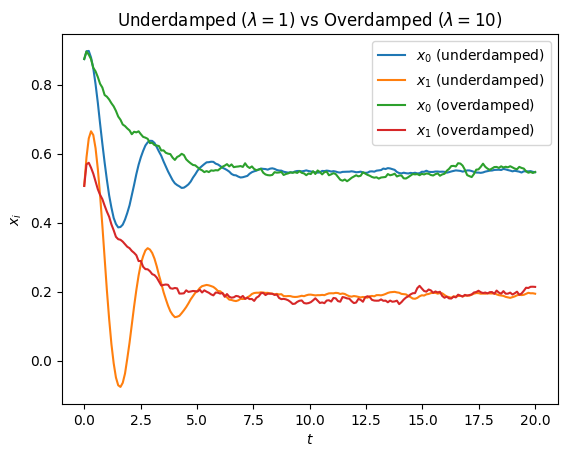

In [7]:
# Plot of x_0 and x_1 (Vertical position of the ends of the stick)
# evolution_plot(ts, torch.hstack([ys_ud[:,0,:2][:,:,None]]), xlabel='$t$', ylabel='$x_i$')

plot_evolution_ud_vs_od(ts, ys_ud[:,0,:2], ys_od[:,0,:2], title=rf'Underdamped ($\lambda=1$) vs Overdamped ($\lambda=10$)')

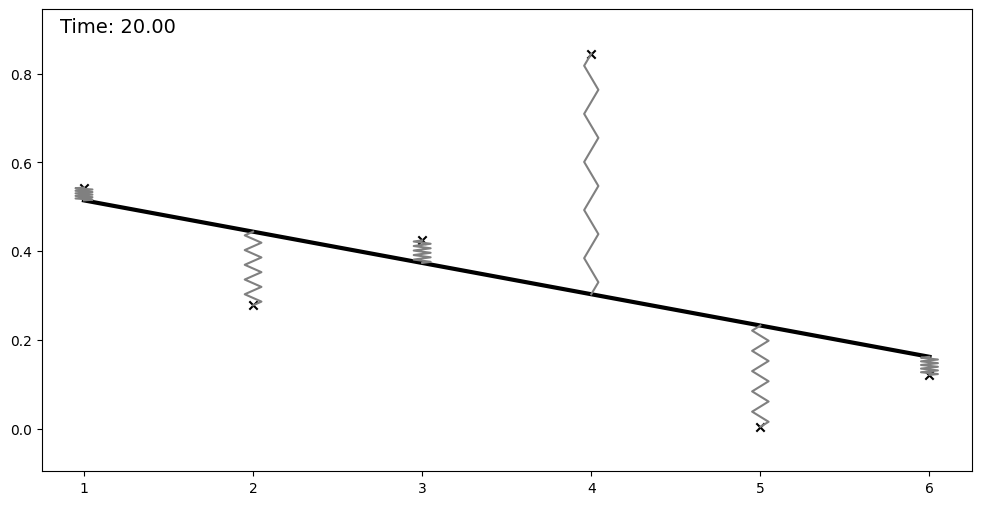

In [6]:
# Make a gif of the springs 
ani_path = animate_springs(ts, ys_ud[:,0,:], u_i, y_i)

## Case 2: $f \in C^\infty (\mathbb{R})$

We can generalize the previous system to one where we have multiply sticks joined by some mechanical joint. This system will converge to the trapezoidal approximation of the function $f$.

In [7]:
np.random.seed(100)
u_i = torch.tensor([1,2,3,4,5,6])
u_max = torch.max(u_i)
u_min = torch.min(u_i)
y_i = torch.tensor(np.random.rand(6))

dof = 4
batch_size, state_size, t_size = 2, (dof+1)*2, 200
sde = GS3DE(dof, u_i, y_i, friction=1, temp=1, k=1, M=1)
ts = torch.linspace(0, 20, t_size)

y0 = torch.rand(size=(batch_size, state_size))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size)

In [8]:
ys_gen[:,0,0].shape

torch.Size([200])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


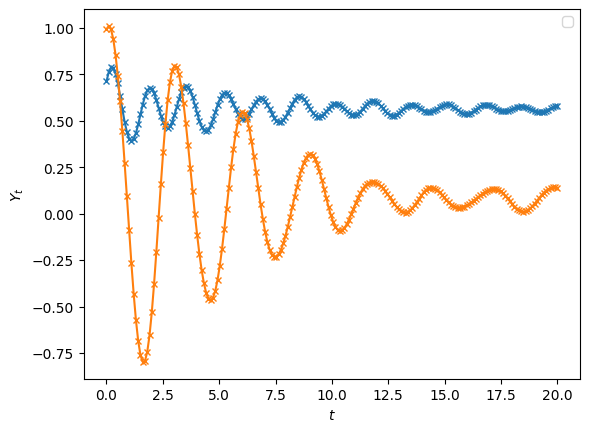

In [9]:
evolution_plot(ts, torch.hstack([ys_gen[:,:1,0][:,:,None], ys_gen[:,:1,1][:,:,None]]), xlabel='$t$', ylabel='$Y_t$', n_pieces=4)

Text(0.5, 1.0, 'Min cost: 0.05400584638118744')

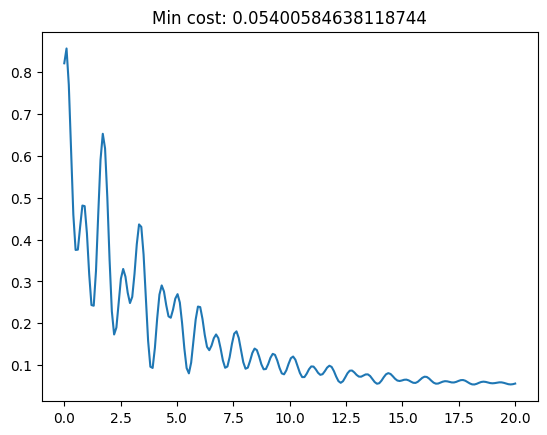

In [10]:
costs = sde.cost(ys_gen[:,0,:]).detach().numpy()
plt.plot(ts, costs)
plt.title(f"Min cost: {costs.min()}")

'anis/ganimation.gif'

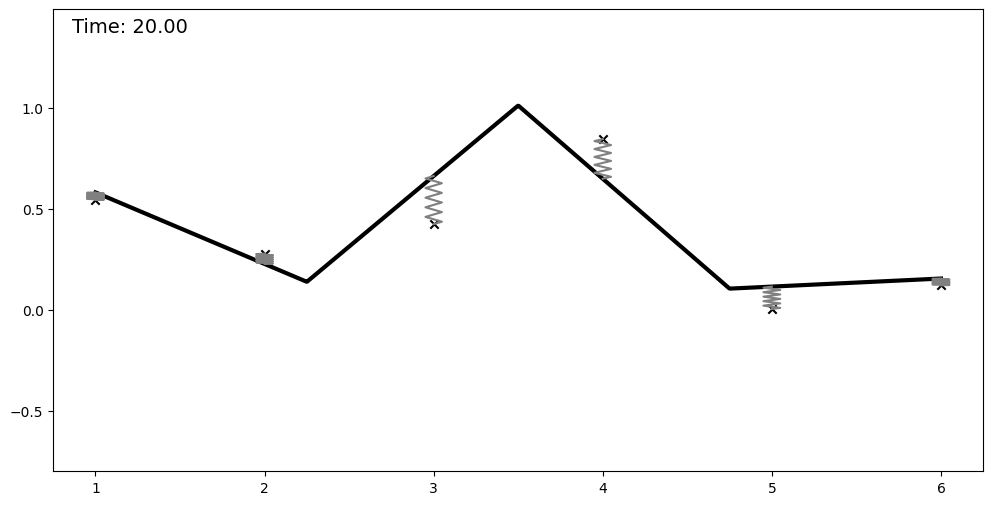

In [11]:
generalized_animation(ts, ys_gen[:,0,:], np.array(u_i), np.array(y_i))

## Case 3: $f: \mathbb{R}^d \longrightarrow \mathbb{R}^m$

In [13]:
np.random.seed(100)

n_pieces = np.array([1,1])
u_i = np.array([[1,2,3,4,5,6], [1,2,3,4,5,6]])

# n_pieces = np.array([4])
# u_i = np.array([[1,2,3,4,5,6]])

u_max = np.max(u_i)
u_min = np.min(u_i)
y_i = np.random.rand(1,6)

n_pieces += np.ones_like(n_pieces)
batch_size, state_size, t_size = 2, np.prod(n_pieces)*2*y_i.shape[0], 200
sde = GGS3DE(n_pieces, u_i, y_i, friction=2, temp=1, k=1, M=1)
ts = torch.linspace(0, 20, t_size)

y0 = torch.rand(size=(batch_size, state_size))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size)

In [4]:
ys_gen[:,0, :25].min()

tensor(-4.8494)

In [5]:
ys_gen[:,0,:sde.N//2].max()

tensor(10.0850)

In [14]:
from sympy import *
from sympy.physics.mechanics import *

import numpy as np

import torch
import torch.nn as nn

class GGS3DE(nn.Module):
    def __init__(
        self, n_pieces, u_i, y_i, friction=0, temp=0, k=1, M=1, kb=1.38064852e-23
    ):
        """
        n_pices (int, NDArray): If int, all directions have same number of pieces. If NDArray, each direction has a different number of pieces. If NDArray, it must have the same length as the dimensions of u_i.
        """
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"

        if isinstance(n_pieces, int):
            n_pieces = np.ones(u_i.shape[0]) * n_pieces

        assert (
            n_pieces.shape[0] == u_i.shape[0]
        ), f"n_pieces must have the same length as the dimensions of u_i. Expected {u_i.shape[0]}, got {n_pieces.shape[0]}"

        self.u_min = u_i.min(axis=1)
        self.u_max = u_i.max(axis=1)
        ell = (self.u_max - self.u_min) / (n_pieces - np.ones_like(n_pieces))

        self.y_i = y_i
        self.u_i = u_i
        self.ell = ell.astype(np.float64)

        self.k = k
        self.M = M / np.prod((n_pieces - np.ones_like(n_pieces)))
        self.kb = kb

        self.friction = friction
        self.temp = temp
        # self.eta_cte = np.sqrt(2 * friction * temp * kb / (M * np.prod(n_pieces)))
        self.eta_cte = float(np.sqrt(2 * friction * temp * kb / M))

        x_symbols = np.empty(
            np.array([n for n in np.append(n_pieces, y_i.shape[0])]), dtype=object
        )

        self.N = np.prod(x_symbols.shape)

        # Iterate over all indices and assign symbols
        for index in np.ndindex(x_symbols.shape):
            # Create symbol and assign it to the corresponding index in the array
            x_symbols[index] = dynamicsymbols(f"x_{''.join(map(str, index))}")

        self.x_symbols = x_symbols
        self.dx_symbols = np.empty_like(x_symbols, dtype=object)
        self.ddx_symbols = np.empty_like(x_symbols, dtype=object)

        for index in np.ndindex(x_symbols.shape):
            self.dx_symbols[index] = x_symbols[index].diff()
            self.ddx_symbols[index] = self.dx_symbols[index].diff()

        # Kinetic energy (translational)
        ktr = 0
        for i in range(len(x_symbols.shape) - 1):
            # Create slices to shift the view one position along the i-th dimension
            slice_front = [slice(None)] * len(x_symbols.shape)
            slice_back = [slice(None)] * len(x_symbols.shape)
            slice_front[i] = slice(1, None)
            slice_back[i] = slice(None, -1)

            # Ensure that the operation is only applied to corresponding spatial components
            for component in range(x_symbols.shape[-1]):
                # Add the squared difference for the same component across neighboring spatial points
                ktr += (self.M / 8) * np.sum(
                    (
                        self.dx_symbols[tuple(slice_front)][..., component]
                        + self.dx_symbols[tuple(slice_back)][..., component]
                    )
                    ** 2
                )

        self.ktr = ktr

        # Kinetic energy (rotational)
        krot = 0

        for i in range(len(x_symbols.shape) - 1):
            slice_front = [slice(None)] * len(x_symbols.shape)
            slice_back = [slice(None)] * len(x_symbols.shape)
            slice_front[i] = slice(1, None)
            slice_back[i] = slice(None, -1)

            for component in range(x_symbols.shape[-1]):
                krot += (self.M / 24) * np.sum(
                    (
                        self.dx_symbols[tuple(slice_front)][..., component]
                        - self.dx_symbols[tuple(slice_back)][..., component]
                    )
                    ** 2
                )

        self.krot = krot

        # Potential energy (cost function)
        U = 0
        for j in range(u_i.shape[1]):
            found_box = False
            for i in np.ndindex(
                tuple(
                    (x_symbols.shape[:-1] - np.ones_like(x_symbols.shape[:-1])).astype(
                        np.int64
                    )
                )
            ):
                hvs = self.vec_heaviside(
                    self.lamd(i, u_i[:, j], div_by_ell=True)
                ) * np.prod(
                    [
                        self.vec_heaviside(
                            self.lamd(i + eb, u_i[:, j], flpind, div_by_ell=True)
                        )
                        for flpind, eb in enumerate(np.eye(u_i.shape[0]))
                    ]
                )

                if abs(hvs) > 0.5:
                    found_box = True
                    U += (
                        k
                        / 2
                        * hvs
                        * sum((self.y_prediction(u_i[:, j], i) - y_i[:, j]) ** 2)
                    )
                    break

            if not found_box:
                print(
                    "Not found. Values of H:",
                    self.vec_heaviside(self.lamd(i, u_i[:, j], div_by_ell=True)),
                    "hvs: ",
                    hvs,
                    "Point:",
                    u_i[:, j],
                    "ProdHvs:",
                    [
                        self.lamd(i + eb, u_i[:, j], flpind, div_by_ell=True)
                        for flpind, eb in enumerate(np.eye(u_i.shape[0]))
                    ],
                )
                raise ValueError(
                    f"Point {j} ({u_i[:, j]-self.u_min}) not found in any box"
                )
        self.U = U

        # Lagrangian
        self.lagrangian = ktr + krot - U
        self.LM = LagrangesMethod(self.lagrangian, self.x_symbols.flatten())
        self.elm = solve(self.LM.form_lagranges_equations(), self.ddx_symbols.flatten())
        self.fddx = [
            lambdify(
                [*self.x_symbols.flatten(), *self.dx_symbols.flatten()],
                self.elm[ddx] - friction * dx / np.prod(n_pieces),
            )
            for ddx, dx in zip(self.ddx_symbols.flatten(), self.dx_symbols.flatten())
        ]

        self.ke = lambdify(
            [*self.x_symbols.flatten(), *self.dx_symbols.flatten()],
            self.ktr + self.krot,
        )
        self.ue = lambdify([*self.x_symbols.flatten()], self.U)
        self.ypred = lambda u: lambdify(
            [*self.x_symbols.flatten()], self.y_prediction(u)
        )

    def lamd(self, i, u, flip_ind=None, div_by_ell=True):
        """Returns the lambda function for the i-th dimension."""
        val = u - i * self.ell - self.u_min
        if div_by_ell:
            val /= self.ell
        if flip_ind is not None:
            val[flip_ind] *= -1
        return val

    def vec_heaviside(self, x):
        """Returns the vectorized heaviside function."""
        return np.prod(np.heaviside(x, 1), axis=0)

    def find_box(self, u):
        """Returns the box where the input u is located."""
        for i in np.ndindex(
            tuple(
                (
                    self.x_symbols.shape[:-1] - np.ones_like(self.x_symbols.shape[:-1])
                ).astype(np.int64)
            )
        ):
            hvs = self.vec_heaviside(self.lamd(i, u, div_by_ell=False)) * np.prod(
                [
                    self.vec_heaviside(self.lamd(i + eb, u, flpind, div_by_ell=False))
                    for flpind, eb in enumerate(np.eye(u.shape[0]))
                ]
            )
            if abs(hvs) > 0.5:
                return i
        raise ValueError(f"Point {u-self.u_min} not found in any box")

    def y_prediction(self, u, i=None):
        """Returns the predicted y given the input u."""
        pred = None
        if i is None:
            i = self.find_box(u)

        ld = self.lamd(i, u)

        for indx, l in enumerate(np.ndindex(tuple(2 * np.ones_like(i)))):
            interpolation = 1
            ind = tuple(np.array(i) + np.array(l))
            flind = np.array(l) == 0
            lds = (1 - ld) * flind + ld * (1 - flind)
            interpolation = np.prod(lds)

            if indx == 0:
                pred = self.x_symbols[ind] * interpolation
            else:
                pred += self.x_symbols[ind] * interpolation
        return pred

    def num_y_prediction(self, u, y):
        q = y[: self.N].T
        ypred = self.ypred(u)
        return ypred(*q)

    def f(self, t, y):
        """y is a tensor of shape (batch_size, state_dim)

        Returns a tensor of shape (batch_size, state_dim)
        """
        q = y[:, : self.N].T
        dq = y[:, self.N :].T

        dqdt = dq
        ddqdt = torch.stack([f(*q, *dq).T for f in self.fddx])
        step = torch.hstack([dqdt.T, ddqdt.T])

        return step

    def g(self, t, y):
        return self.eta_cte * torch.ones_like(y)

    def cost(self, y):
        q = y[:, : self.N].T
        return self.ue(*q)

    def kinetic_energy(self, y):
        q = y[:, : self.N].T
        dq = y[:, self.N :].T

        return self.ke(*q, *dq)
    
sde = GGS3DE(n_pieces, u_i, y_i, friction=2, temp=1, k=1e-15, M=1e-15)


In [6]:
sde = GGS3DE(n_pieces, u_i, y_i, friction=2, temp=1, k=1e-15, M=1e-15)


'anis/animation_3d_11.gif'

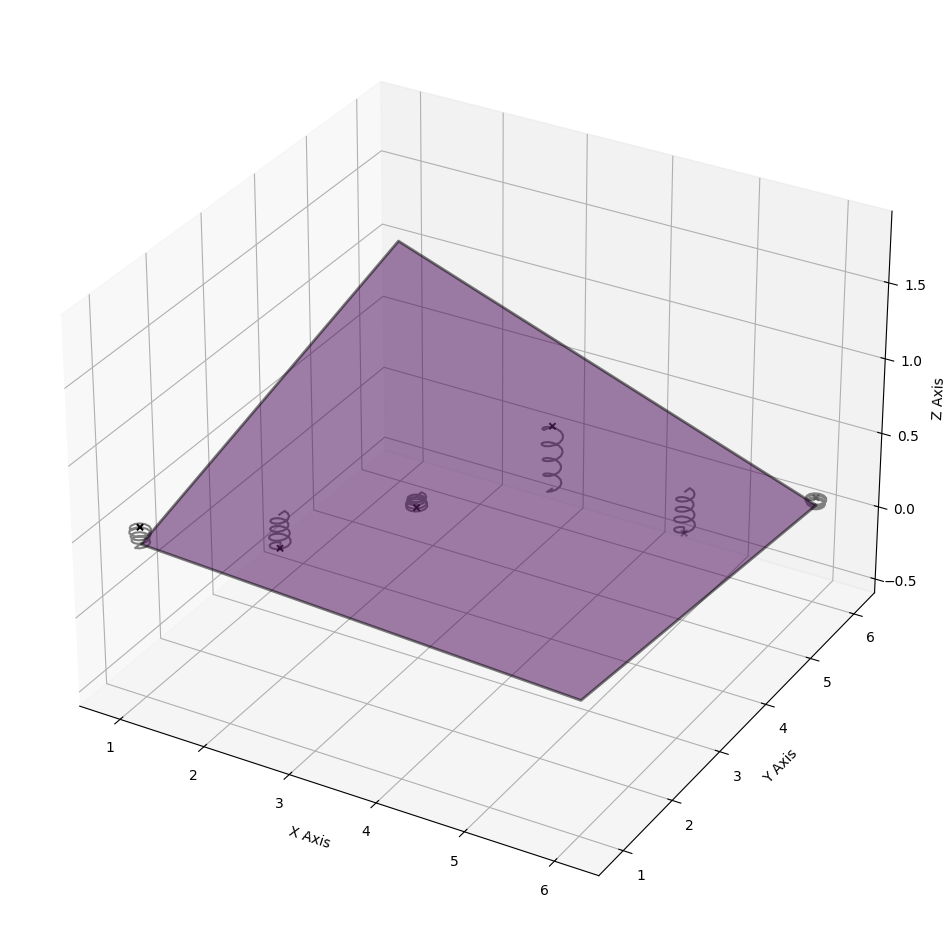

In [20]:
generalized_animation_3d(ts, ys_gen[:,0,:], u_i, y_i, n_pieces, sde, path="anis/animation_3d_11.gif")

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.animation import FuncAnimation, PillowWriter
import math

def spring_3d(start, end, nodes, width):
    """Generate points for a spring in 3D."""
    print("start", start)
    print("end", end)
    print("nodes", nodes)
    print("width", width)
    
    nodes = max(int(nodes), 2)
    diff = np.array(end) - np.array(start)
    length = np.linalg.norm(diff)
    u_t = diff / length

    # Find a vector perpendicular to u_t
    if (u_t == [0, 0, 1]).all() or (u_t == [0, 0, -1]).all():
        u_n = np.cross(u_t, np.array([0, 1, 0]))
    else:
        u_n = np.cross(u_t, np.array([0, 0, 1]))

    u_n = u_n / np.linalg.norm(u_n)
    u_b = np.cross(u_t, u_n)

    spring_coords = np.zeros((3, nodes + 2))
    spring_coords[:, 0], spring_coords[:, -1] = start, end

    for i in range(1, nodes + 1):
        angle = math.pi * i
        displacement = width * math.cos(angle) * u_n + width * math.sin(angle) * u_b
        spring_coords[:, i] = start + u_t * (length * i / (nodes + 1)) + displacement

    return spring_coords

def generalized_animation_3d(ts, ys, u_i, y_i, n_pieces, sde, path="anis/animation_3d.gif", frame_skip=1):
    """Animates the surface movement based on the solution array in 3D."""
    
    time_steps = len(ts)
    n_vars = int(ys.shape[1] / 2)  # Assuming ys has x and y values for each grid point

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Preparing the grid (assuming it's uniform)
    u_x, u_y = np.meshgrid(np.linspace(u_i[0, :].min(), u_i[0, :].max(), n_pieces[0]), 
                           np.linspace(u_i[1, :].min(), u_i[1, :].max(), n_pieces[1]))
    
    springs = [ax.plot([], [], [], 'gray')[0] for _ in range(len(u_i[0]))]

    z_min = ys[:, :n_vars].min()
    z_max = ys[:, :n_vars].max()

    z_min = np.min([z_min, y_i.min()])
    z_max = np.max([z_max, y_i.max()])

    # Function to get Z data from the solution
    def get_z_data(frame_number):
        return np.array(ys[frame_number][:n_vars]).reshape(n_pieces)

    # No need to set anything in init for Poly3DCollection, just return a blank artist
    def init():
        return []

    def update(frame):
        # Clearing the axes allows for the new surface to be drawn without residual old data
        ax.clear()
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        zs = get_z_data(frame)
        ax.set_zlim(z_min, z_max)
        ax.scatter(u_i[0, :], u_i[1, :], y_i[0, :], label="Data points", marker="x", c="black")
        ax.plot_surface(u_x, u_y, zs, cmap='viridis')
        time_text.set_text(f"Time: {ts[frame]:.2f}s")

        # for i, spring in enumerate(springs):
        #     print(u_i[:, i], ys[frame, :])
        #     y_pred = sde.num_y_prediction(u_i[:, i], ys[frame, :])
        #     spring.set_data_3d(*spring_3d([u_i[0, i], u_i[1, i], y_pred], 
        #                                   [u_i[0, i], u_i[1, i], y_i[i]], 10, 0.1))

        return fig,

    time_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes, color="black")

    ani = FuncAnimation(fig, update, frames=np.arange(0, time_steps, frame_skip), init_func=init, blit=False)

    writer = PillowWriter(fps=20)
    ani.save(path, writer=writer)

    return path

In [7]:
ys_gen[:,0,:].shape

torch.Size([200, 50])

In [15]:
5*5*2*y_i.shape[0]

50

In [10]:
ys_gen.shape

torch.Size([200, 2, 50])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


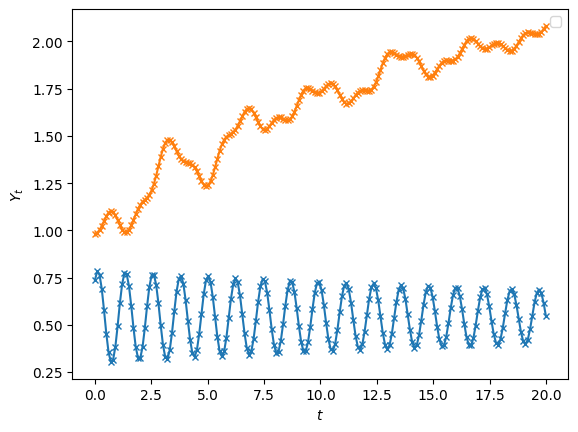

In [9]:
evolution_plot(ts, torch.hstack([ys_gen[:,:1,0][:,:,None], ys_gen[:,:1,1][:,:,None]]), xlabel='$t$', ylabel='$Y_t$', n_pieces=4)

Text(0.5, 1.0, 'Min cost: 2.0831546147329263e-17')

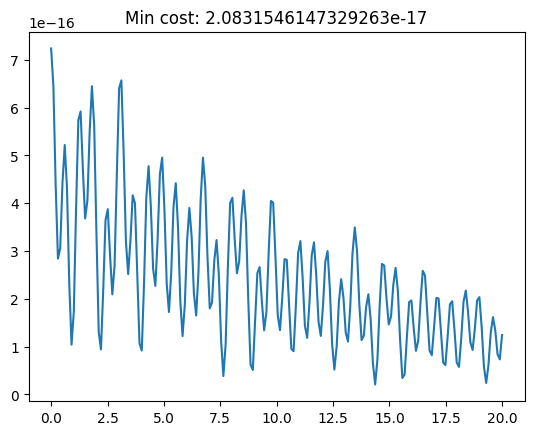

In [10]:
costs = sde.cost(ys_gen[:,0,:])
plt.plot(ts, costs)
plt.title(f"Min cost: {costs.min()}")

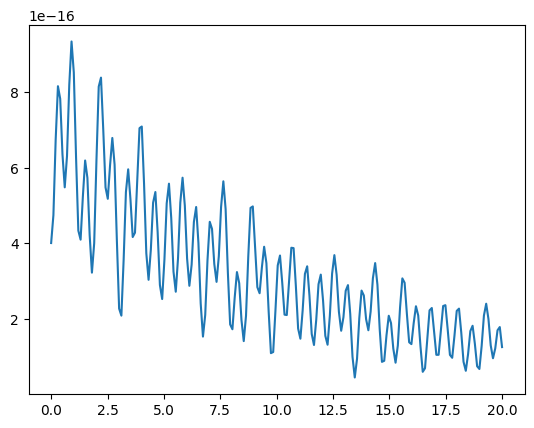

In [11]:
costs = sde.kinetic_energy(ys_gen[:,0,:])
plt.plot(ts, costs)

'anis/ggs3de.gif'

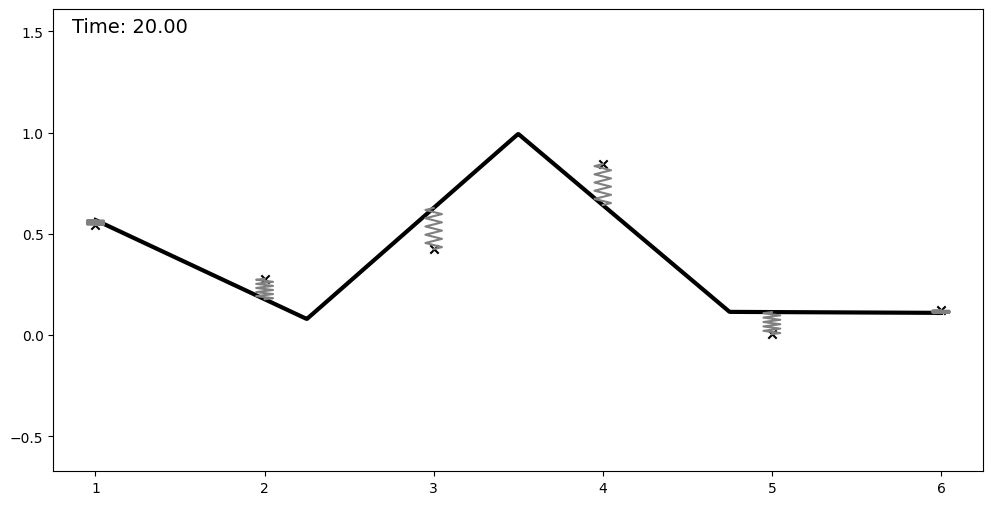

In [43]:
generalized_animation(ts, ys_gen[:,0,:], u_i[0], y_i[0], path='anis/ggs3de.gif')

In [25]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    # transforms.Resize(14),  # Resize the image to 14x14
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])


trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)

u_i_train, y_train = next(iter(trainloader))
y_i_train = torch.nn.functional.one_hot(y_train, num_classes=10).float()

u_i_train = u_i_train.numpy()
y_i_train = y_i_train.numpy()


Text(0.5, 1.0, 'Label: 4')

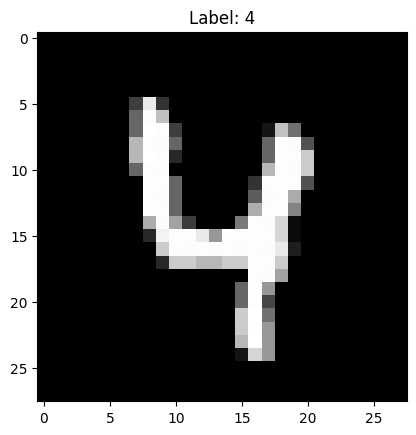

In [31]:
u_i_train_coarse = u_i_train.reshape(-1, 28, 28)

# draw a random sample
idx = np.random.randint(0, len(trainset))
u_i = u_i_train_coarse[idx]
y_i = y_i_train[idx]

plt.imshow(u_i, cmap='gray')
plt.title(f"Label: {np.where(y_i==1)[0][0]}")